# Template Matching using NCC and PCE (Peak to Correlation Energy)

In [50]:
from skimage.io import imread
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as patches
from scipy.signal import correlate2d, correlate

In [5]:
orig_img = imread('lena.png')
orig_img = rgb2grey(orig_img)

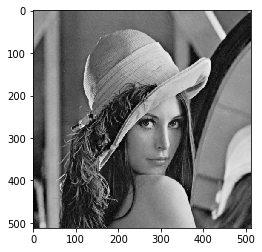

In [6]:
plt.imshow(orig_img, cmap='gray')

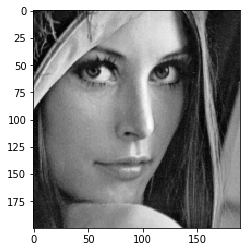

In [7]:
face = orig_img[210:410,210:400]
plt.imshow(face, cmap='gray')

## Calculate NCC (Normalized Cross Correlation) matrix
**Note:** Since no further transformation have been applied on the face image, there should be at least one entry where NCC is 1.

In [8]:
def ncc(img, kernel, shift=(0,0)):
    
    shift_row, shift_col = shift
    
    mean_kernel = np.mean(kernel)
    zero_shifted_kernel = kernel - mean_kernel
     
    img_patch = img[shift_row:shift_row+kernel.shape[0],shift_col:shift_col+kernel.shape[1]]
    mean_img_patch = np.mean(img_patch)
    zero_shifted_img_patch = img_patch - mean_img_patch

    pow_zero_shifted_img_patch = zero_shifted_img_patch * zero_shifted_img_patch
    pow_zero_shifted_kernel = zero_shifted_kernel * zero_shifted_kernel

    numerator = (zero_shifted_img_patch * zero_shifted_kernel).sum()
    denominator = np.sqrt(pow_zero_shifted_img_patch.sum() * pow_zero_shifted_kernel.sum())

    return numerator / denominator

def circular_ncc(img, kernel):
    
    ncc_matrix = np.zeros(img.shape)
    
    for shift_row in range(img.shape[0]):
        for shift_col in range(img.shape[1]):
            shifted_img = np.roll(img, -shift_col, axis=1)
            shifted_img = np.roll(shifted_img, -shift_row, axis=0)
            ncc_matrix[shift_row][shift_col] = ncc(shifted_img, kernel)
    return ncc_matrix

In [9]:
cc_matrix = circular_ncc(orig_img,face)
print(cc_matrix)

[[-0.09271381 -0.09720313 -0.10141722 ... -0.08567971 -0.08771174
  -0.08967603]
 [-0.09592553 -0.10056137 -0.10546497 ... -0.08786043 -0.09027169
  -0.09265147]
 [-0.09925575 -0.10439117 -0.10980485 ... -0.09003855 -0.09290167
  -0.0954775 ]
 ...
 [-0.08126241 -0.08608458 -0.09012322 ... -0.07703054 -0.07797982
  -0.07891499]
 [-0.0848465  -0.08942748 -0.09355654 ... -0.0797559  -0.08112243
  -0.08238279]
 [-0.08880415 -0.09336552 -0.09747492 ... -0.08272244 -0.08445993
  -0.0861064 ]]


## Finally, we also nicely visualize our NCC matrix as 3D plot 

In [36]:
def plot_3d(matrix):
    x = []
    y = []
    z = []

    for (i,j), v in np.ndenumerate(matrix):
        x.append(i)
        y.append(j)
        z.append(v)

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x,y,z, cmap=plt.cm.plasma, linewidth=0.2)
    ax.set_zlim(-1., 1.)
    plt.show()

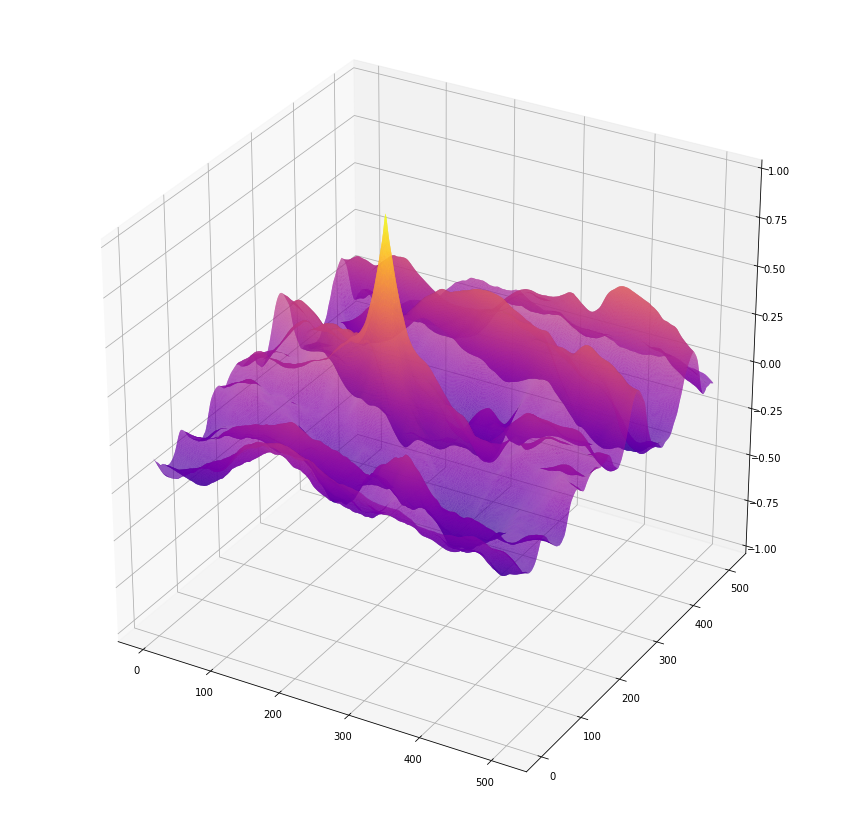

In [11]:
plot_3d(cc_matrix)

## Extract value and position of max peak

In [12]:
shift_y, shift_x = np.unravel_index(cc_matrix.argmax(), cc_matrix.shape)
print("Peak Location: %i / %i" % (shift_x, shift_y))
print("NCC Score: %f" % cc_matrix[shift_y][shift_x])

Peak Location: 210 / 210
NCC Score: 1.000000


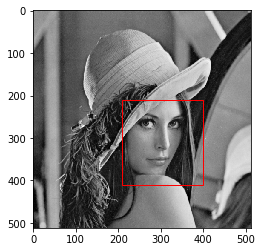

In [14]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(orig_img, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((shift_x,shift_y), face.shape[1], face.shape[0], linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## PCE (Peak to Correlation Energy)
**Note:** Since we already have the NCC matrix, we can easily compute the peak to correlation energy. 
In fact, PCE will "emphasize" the result. In other words, all uniform regions will be surpress and peaks will be further emphasized.

In [122]:
def pce(matrix):
    
    squared_m = matrix*matrix
    
    # We can easily compute the pce matrix by correlation with a filter matrix
    # We choose a filter size of 11x11. The center (peak) needs to be set to 0 zero 
    filter = np.full((11,11), 1/(11*11-1)) # Number of elements in its neighbourhood
    filter[5,5] = 0

    pce = correlate2d(squared_m, filter, boundary='wrap')
    pce = np.roll(pce,-5, axis=1)
    pce = np.roll(pce,-5, axis=0)
    
    return pce

In [123]:
pce_matrix = pce(cc_matrix)
print(pce_matrix)

[[0.00945029 0.01015158 0.01092499 ... 0.00757417 0.00815045 0.0087879 ]
 [0.01017314 0.01094765 0.01178346 ... 0.00804783 0.00870754 0.00942979]
 [0.01094705 0.01179514 0.012694   ... 0.00855968 0.00930852 0.01012066]
 ...
 [0.00756901 0.00806733 0.00865863 ... 0.00634368 0.00670564 0.00712134]
 [0.00815316 0.00871516 0.00936467 ... 0.00672838 0.00715553 0.00763917]
 [0.0087777  0.00940754 0.01011832 ... 0.00713591 0.00763443 0.00819199]]


In [124]:
shift_y, shift_x = np.unravel_index(pce_matrix.argmax(), pce_matrix.shape)
print("Peak Location: %i / %i" % (shift_x, shift_y))
print("PCE Score: %f" % pce_matrix[shift_y][shift_x])

Peak Location: 210 / 210
PCE Score: 0.702434


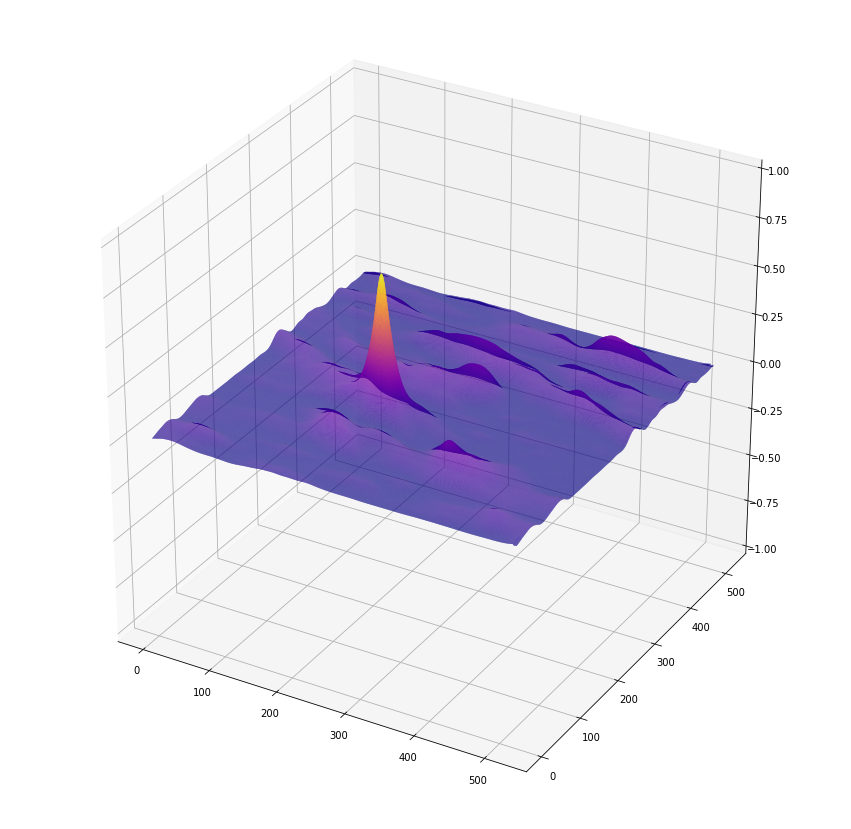

In [125]:
plot_3d(pce_matrix)